In [1]:
import pandas as pd
import numpy as np
import joblib

load_path = "/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/"

# 불러오기
X_alerts = pd.read_csv(load_path + "X_alerts.csv")
X_scaled = np.load(load_path + "X_scaled.npy")
shap_pos_clipped = np.load(load_path + "shap_pos_clipped.npy")
FEATURES = joblib.load(load_path + "FEATURES.pkl")

print("불러오기 완료!")
print("X_alerts shape:", X_alerts.shape)
print("X_scaled shape:", X_scaled.shape)
print("shap_pos_clipped shape:", shap_pos_clipped.shape)
print("FEATURES 개수:", len(FEATURES))


불러오기 완료!
X_alerts shape: (692, 61)
X_scaled shape: (692, 61)
shap_pos_clipped shape: (692, 61)
FEATURES 개수: 61


In [89]:
# alerts_with_X 저장
save_path = "/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/alerts_with_sses.csv"
alerts_with_sses.to_csv(save_path, index=False)

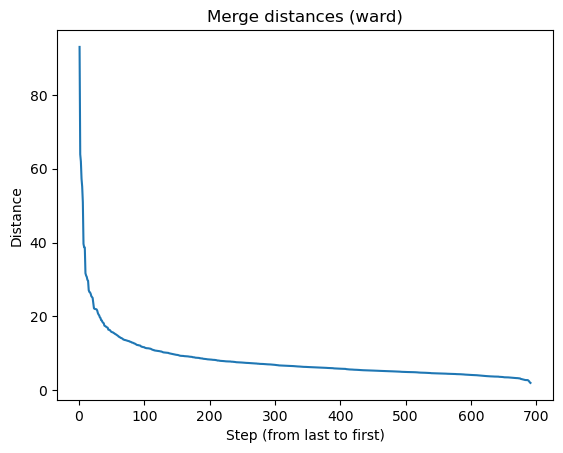

Natural cut point suggests ~2 clusters
{1: 557, 2: 135}


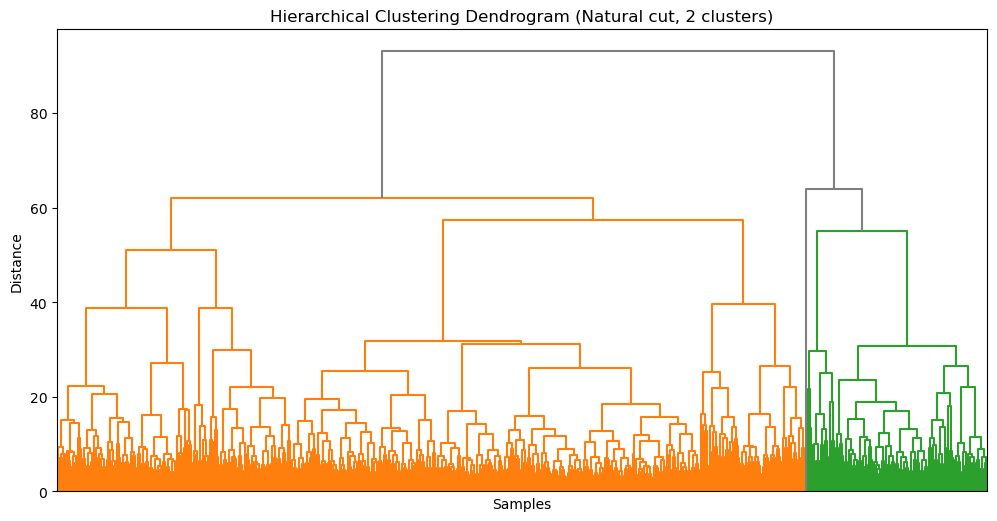

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# === 1) linkage 계산 ===
Z = linkage(X_scaled, method="ward")

# === 2) 병합 거리 확인 ===
distances = Z[:, 2]  # 세 번째 열이 병합 거리
plt.plot(range(1, len(distances)+1), distances[::-1])  # 큰 것부터 보기 쉽게 역순
plt.title("Merge distances (ward)")
plt.xlabel("Step (from last to first)")
plt.ylabel("Distance")
plt.show()

# === 3) 가장 큰 점프 찾기 ===
diffs = np.diff(distances)  # 인접 거리 차이
cut_idx = np.argmax(diffs)  # 점프가 가장 큰 지점
n_clusters = len(distances) - cut_idx  # 클러스터 개수

print(f"Natural cut point suggests ~{n_clusters} clusters")

# === 4) 해당 natural cut point로 클러스터링 ===
clusters = fcluster(Z, t=distances[cut_idx], criterion="distance")

# === 5) 클러스터링 결과 확인 ===
unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))

# === 6) 덴도그램 시각화 ===
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    color_threshold=distances[cut_idx],
    above_threshold_color="gray",
    no_labels=True
)
plt.title(f"Hierarchical Clustering Dendrogram (Natural cut, {n_clusters} clusters)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


## Features

In [10]:
X_with_cluster = X_alerts.copy()
X_with_cluster["Cluster"] = clusters
print(X_with_cluster["Cluster"].value_counts())


Cluster
1    557
2    135
Name: count, dtype: int64


=== Top5 features per cluster ===
Cluster 1: ['Time_24h', 'mean_intensity_1h', 'hungry', 'Z_Previous_4', '15m_G_Diff_7']
Cluster 2: ['Z_Previous_4', 'Time_24h', 'mean_intensity_1h', 'G_minus_T_pre_2h', 'G_minus_T_pre_1.5h']

=== Cluster 1 ===
Plotting Time_24h vs mean_intensity_1h


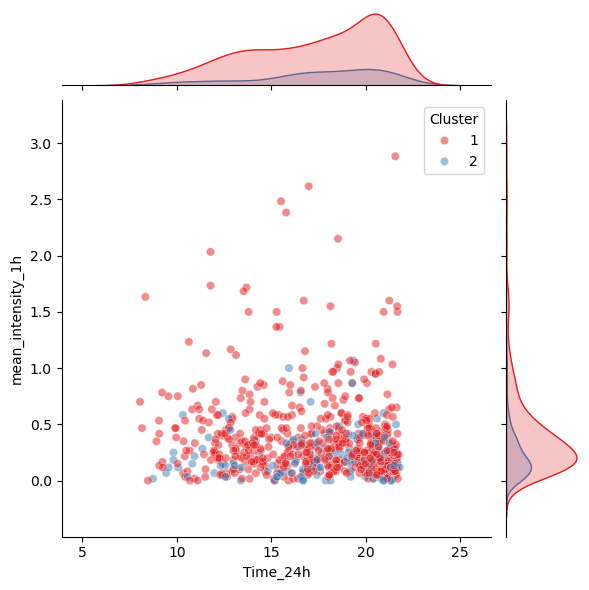

Plotting Time_24h vs hungry


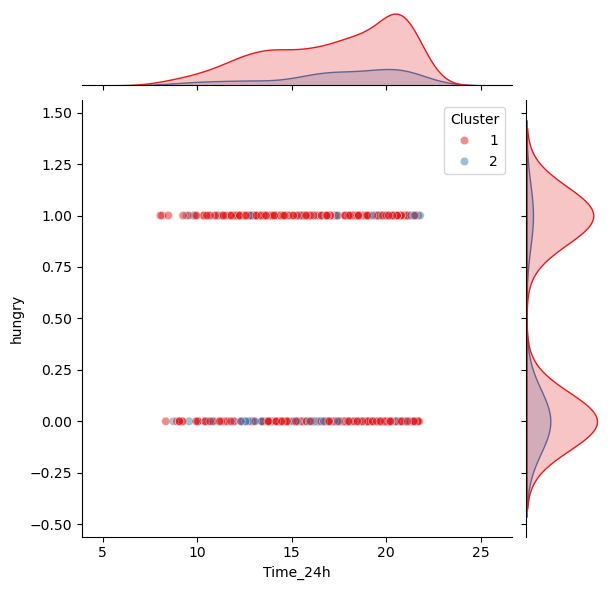

Plotting Time_24h vs Z_Previous_4


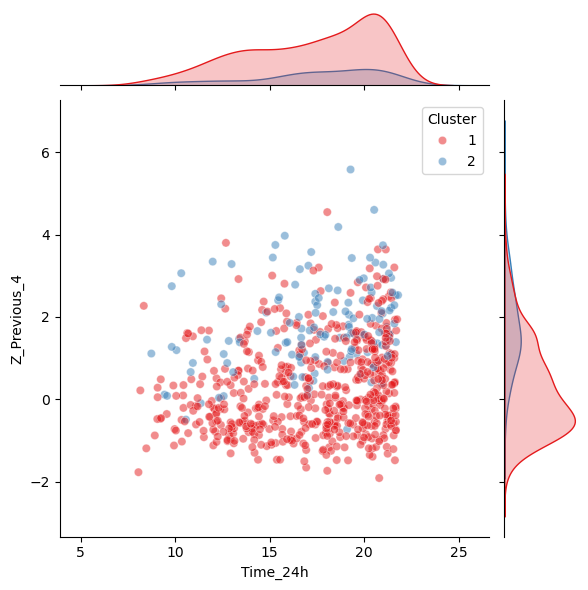

Plotting Time_24h vs 15m_G_Diff_7


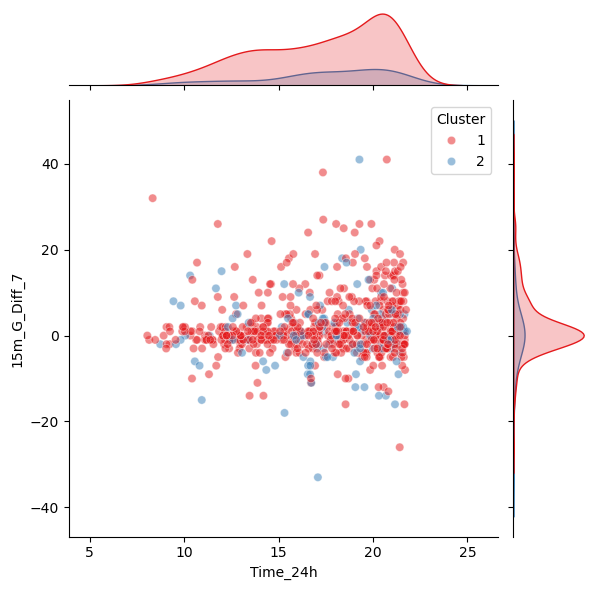

Plotting mean_intensity_1h vs hungry


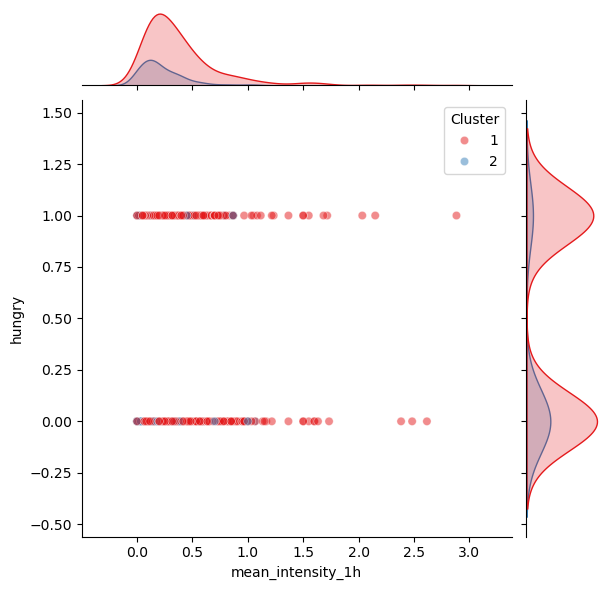

Plotting mean_intensity_1h vs Z_Previous_4


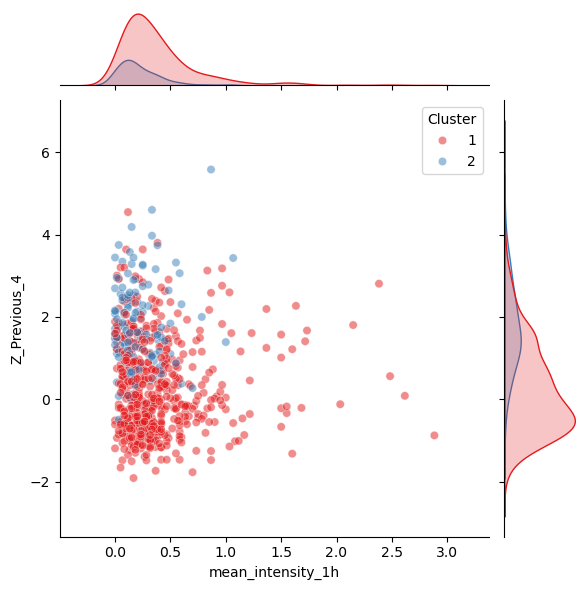

Plotting mean_intensity_1h vs 15m_G_Diff_7


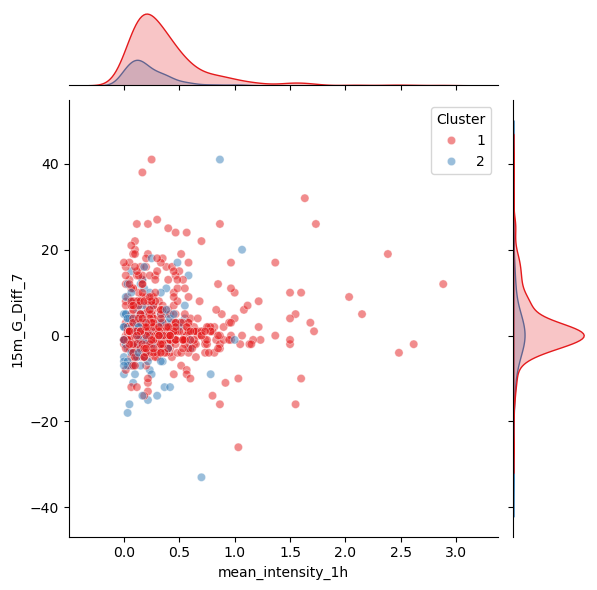

Plotting hungry vs Z_Previous_4


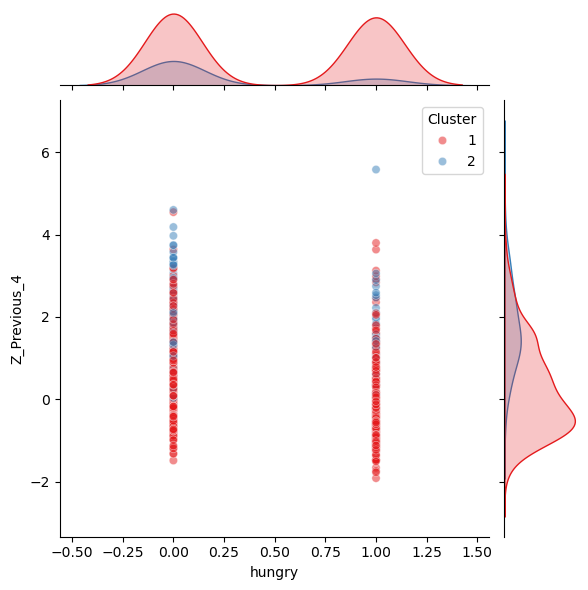

Plotting hungry vs 15m_G_Diff_7


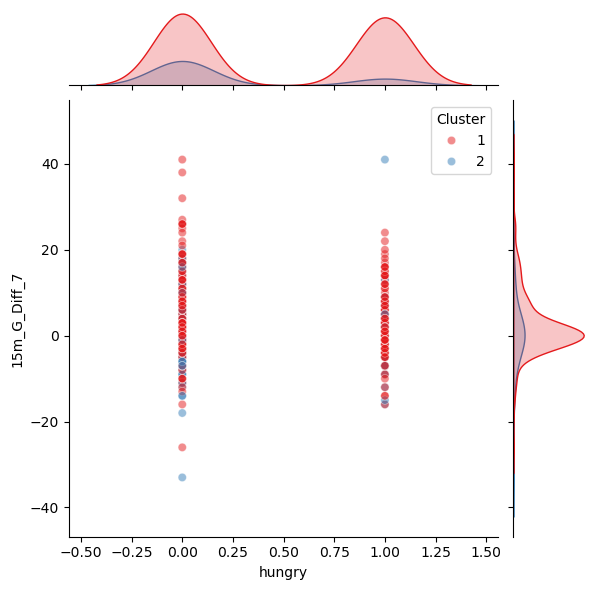

Plotting Z_Previous_4 vs 15m_G_Diff_7


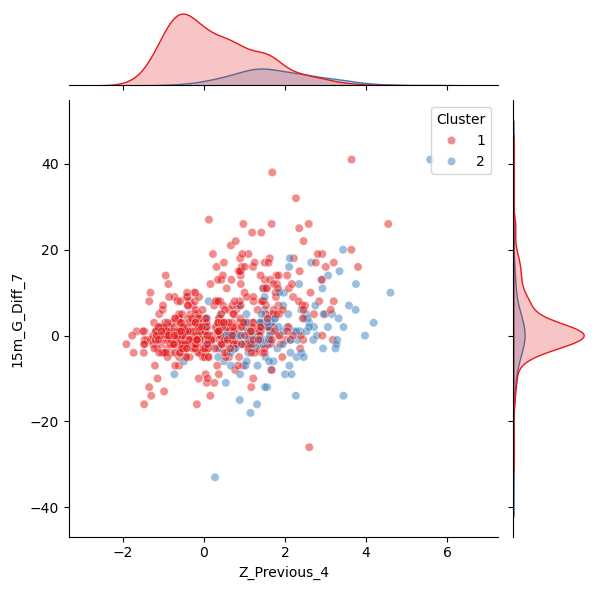


=== Cluster 2 ===
Plotting Z_Previous_4 vs Time_24h


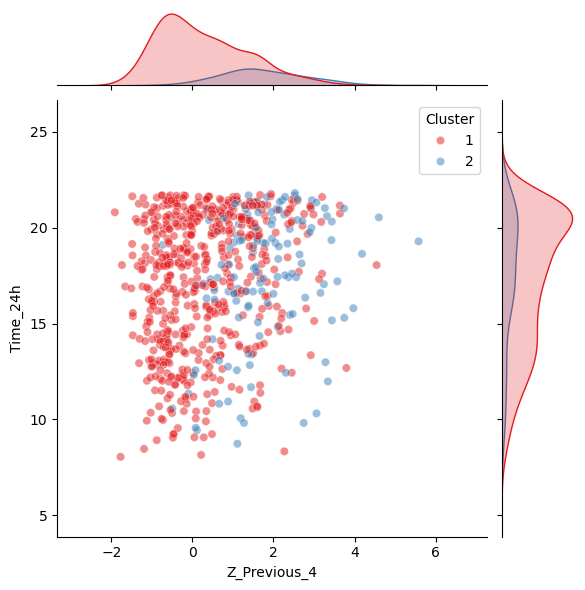

Plotting Z_Previous_4 vs mean_intensity_1h


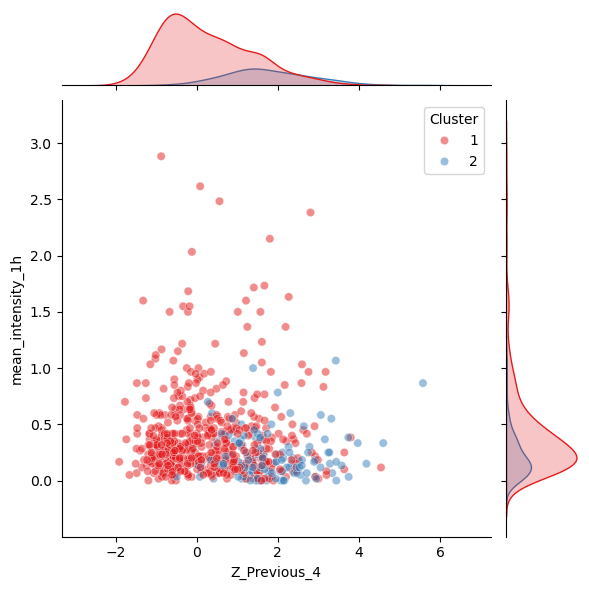

Plotting Z_Previous_4 vs G_minus_T_pre_2h


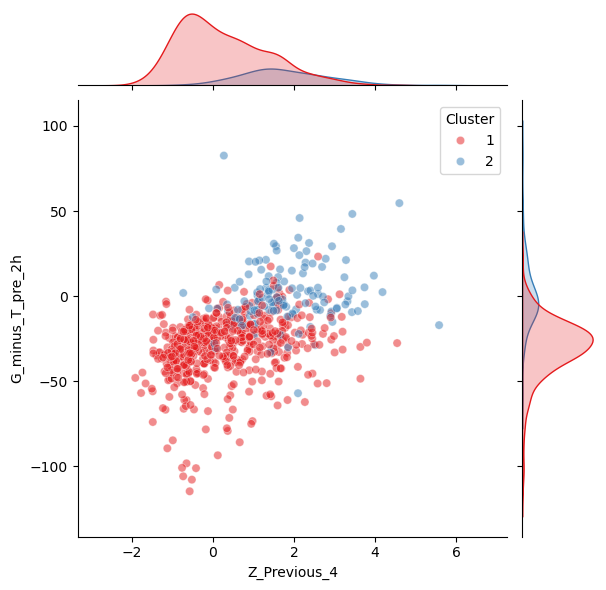

Plotting Z_Previous_4 vs G_minus_T_pre_1.5h


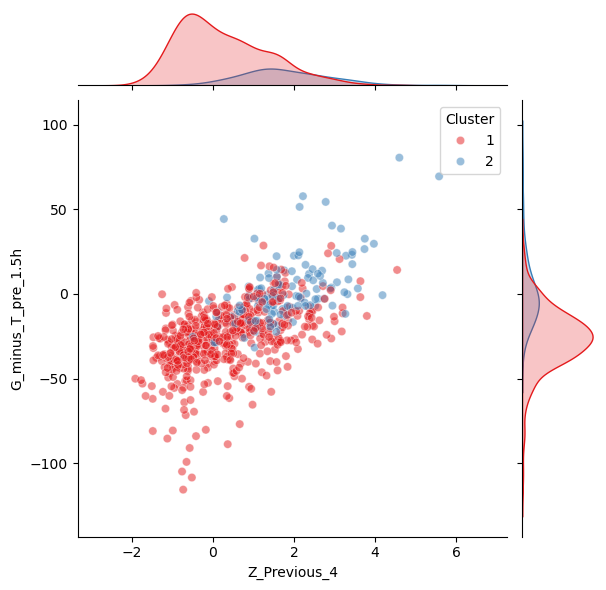

Plotting Time_24h vs mean_intensity_1h


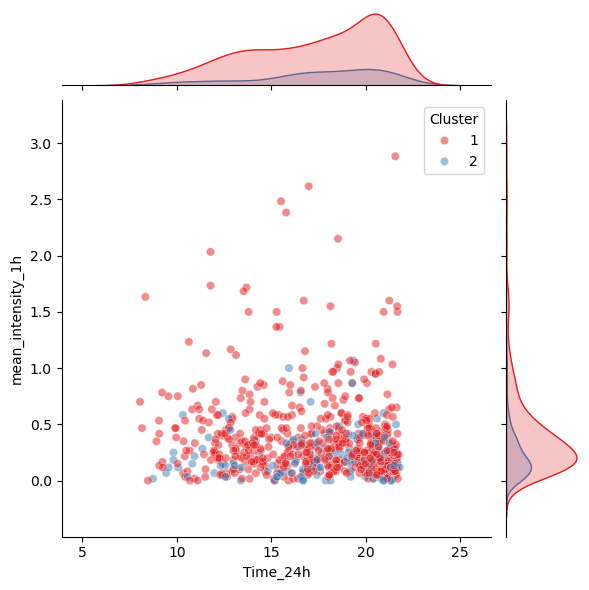

Plotting Time_24h vs G_minus_T_pre_2h


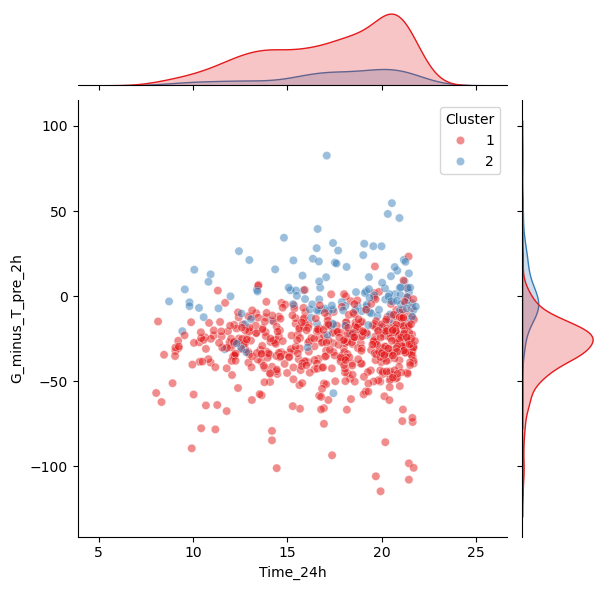

Plotting Time_24h vs G_minus_T_pre_1.5h


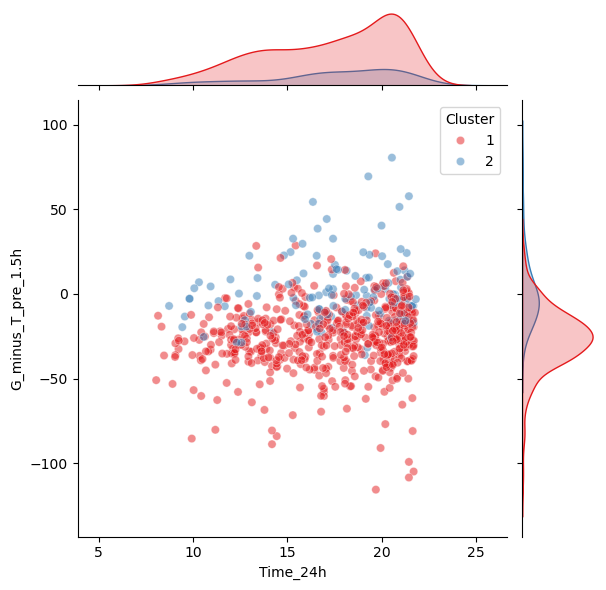

Plotting mean_intensity_1h vs G_minus_T_pre_2h


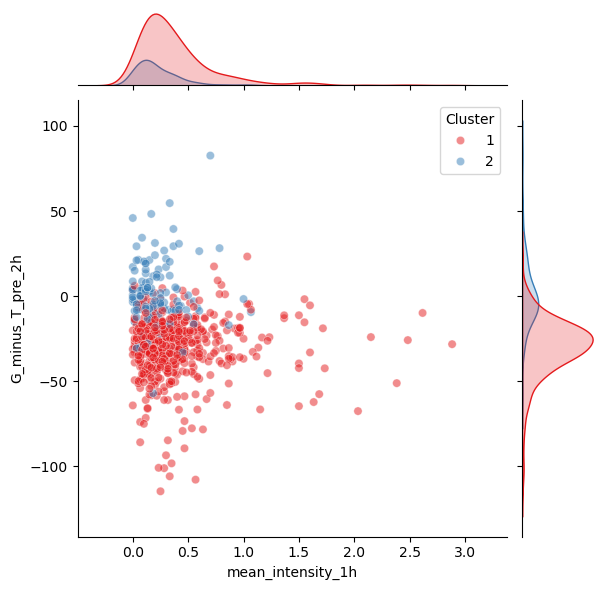

Plotting mean_intensity_1h vs G_minus_T_pre_1.5h


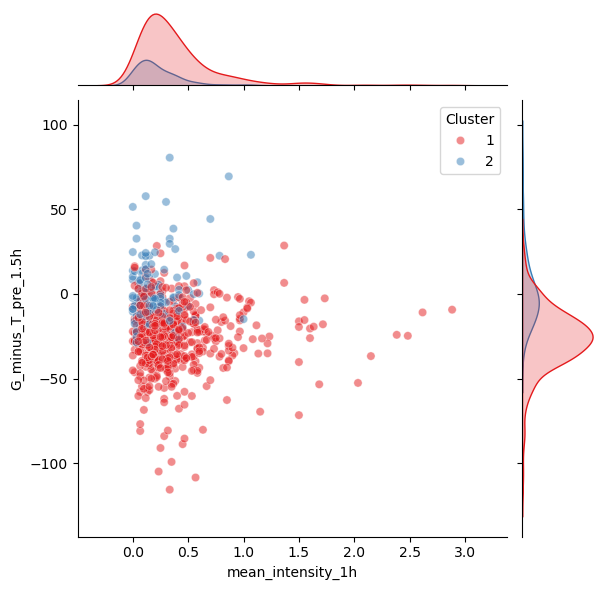

Plotting G_minus_T_pre_2h vs G_minus_T_pre_1.5h


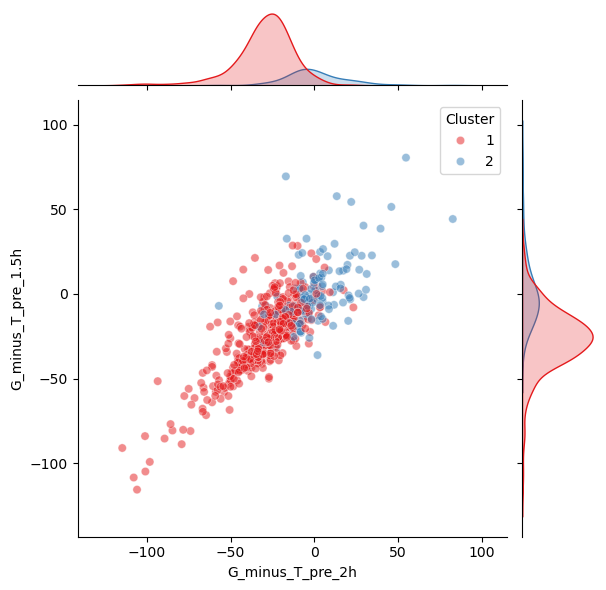

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# === 1) SHAP 값 DataFrame 준비 ===
shap_df = pd.DataFrame(shap_pos_clipped, columns=FEATURES, index=X_with_cluster.index)
shap_df["Cluster"] = X_with_cluster["Cluster"]

# === 2) 클러스터별 평균 SHAP 기반 Top3 features 뽑기 ===
cluster_means = shap_df.groupby("Cluster").mean()
top_feats = {
    clust: cluster_means.loc[clust].sort_values(ascending=False).head(5).index.tolist()
    for clust in cluster_means.index if clust in [1,2]  # Cluster 3 제외
}

print("=== Top5 features per cluster ===")
for clust, feats in top_feats.items():
    print(f"Cluster {clust}: {feats}")

# === 3) Cluster 1,2 데이터만 준비 ===
df_plot = X_with_cluster[X_with_cluster["Cluster"].isin([1,2])]

# === 4) 각 클러스터별 Top3 feature 조합 시각화 ===
for clust, feats in top_feats.items():
    print(f"\n=== Cluster {clust} ===")
    for f1, f2 in itertools.combinations(feats, 2):
        print(f"Plotting {f1} vs {f2}")
        sns.jointplot(
            data=df_plot,
            x=f1, y=f2,
            hue="Cluster",
            palette="Set1",
            alpha=0.5
        )
        plt.show()


## Z_Previous_4, G_minus_T_pre_2h, G_minus_T_pre_1.5h show the most distinct distributions

# Pairwise scatter plot

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


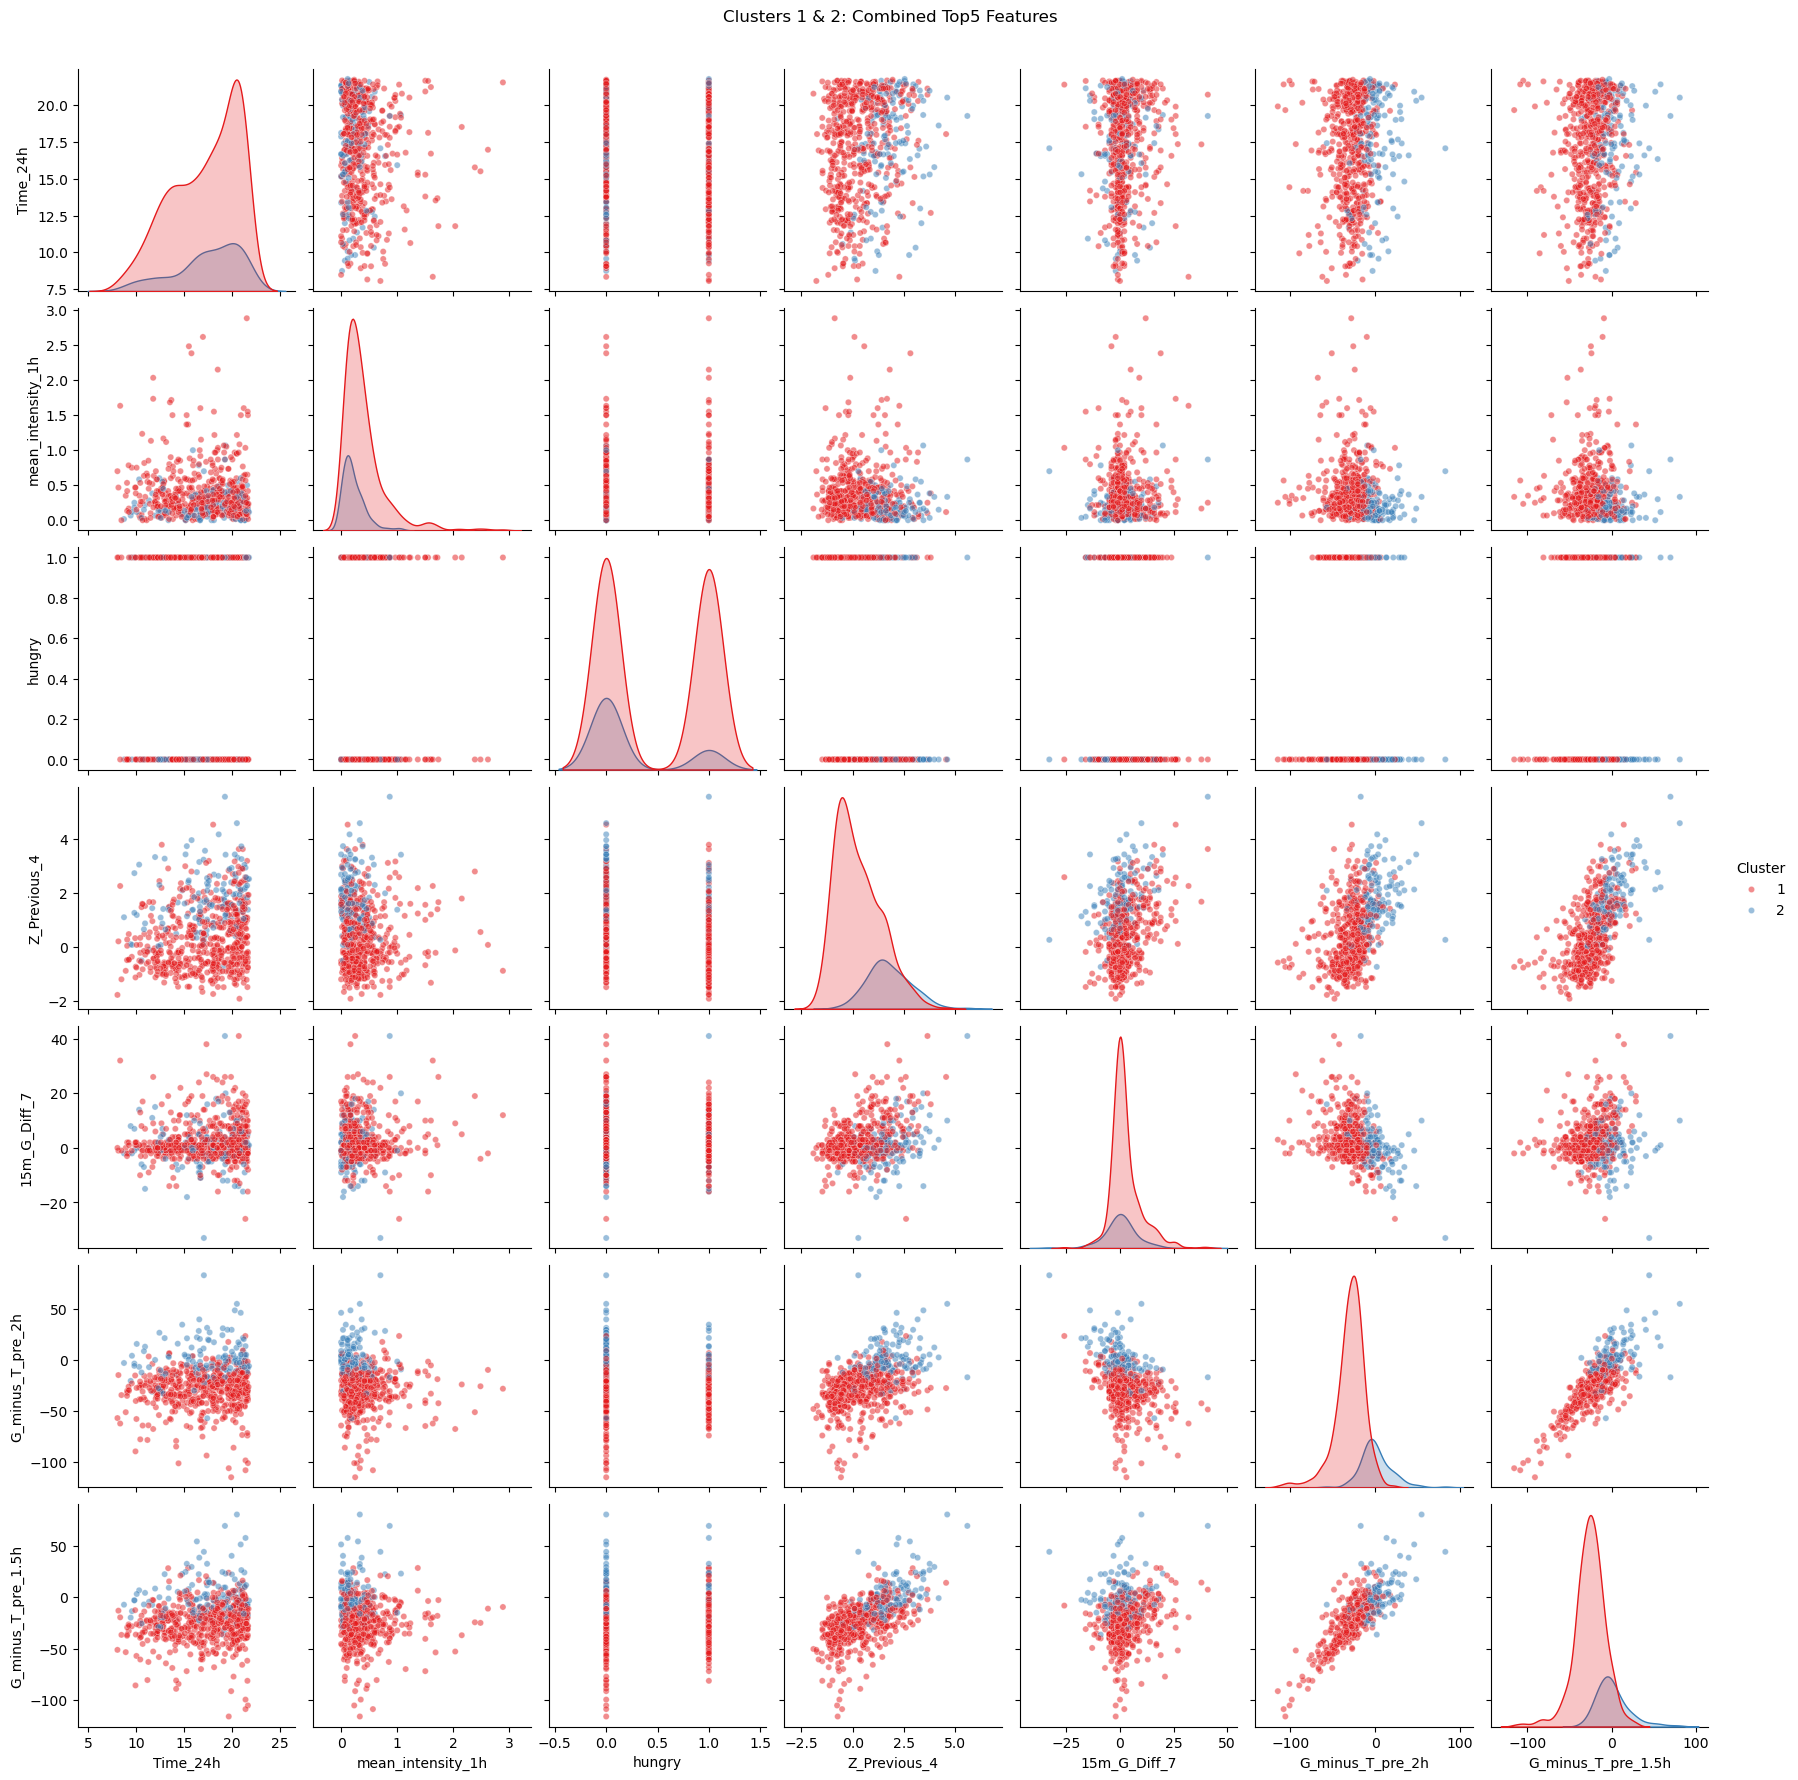

In [21]:
# === Cluster 1,2 데이터만 준비 ===
df_plot = X_with_cluster[X_with_cluster["Cluster"].isin([1,2])]

# === Cluster 1+2 Top5 합집합 ===
combined_feats = [
    'Time_24h', 'mean_intensity_1h', 'hungry', 
    'Z_Previous_4', '15m_G_Diff_7', 
    'G_minus_T_pre_2h', 'G_minus_T_pre_1.5h'
]

# === pairplot ===
sns.pairplot(
    data=df_plot,
    vars=combined_feats,
    hue="Cluster",
    palette="Set1",
    plot_kws={"alpha": 0.5, "s": 20}
)
plt.suptitle("Clusters 1 & 2: Combined Top5 Features", y=1.02)
plt.show()


# How Stress

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


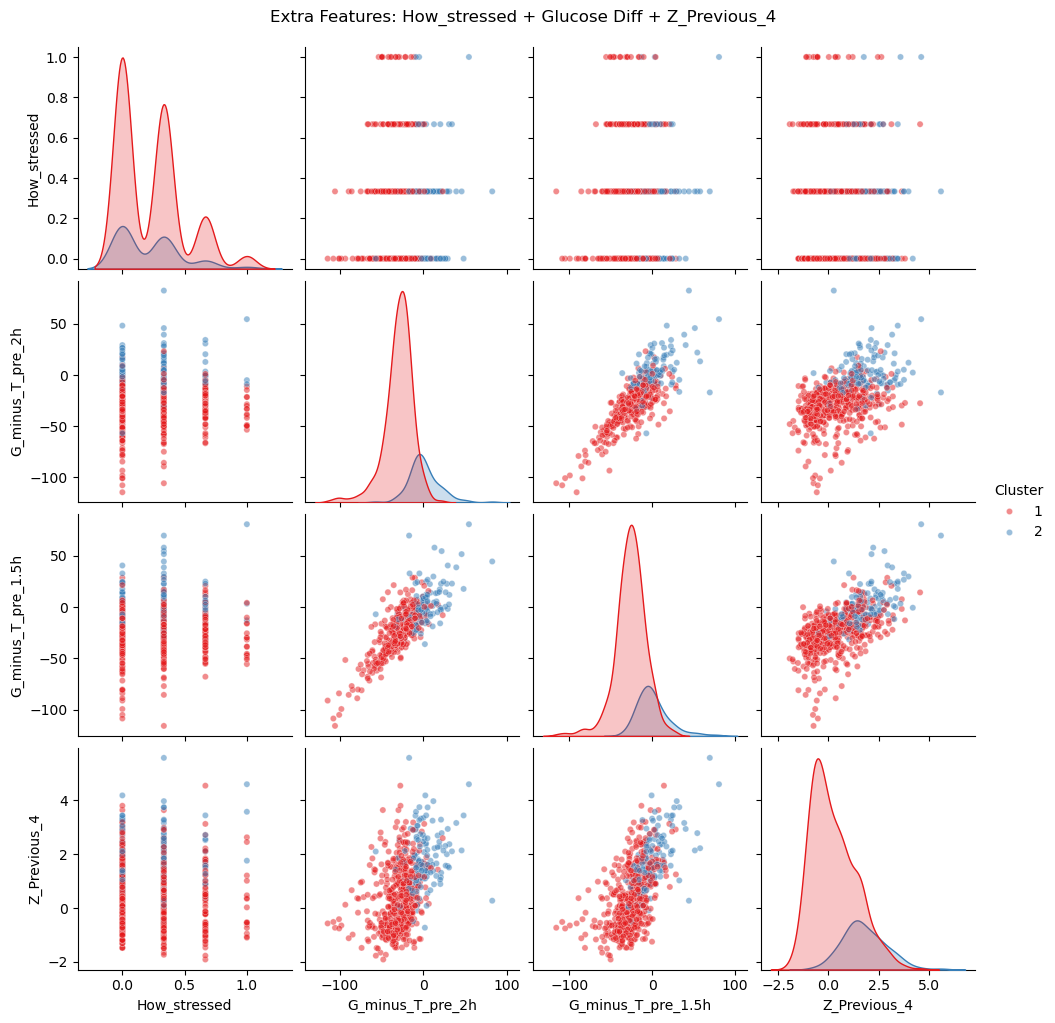

In [14]:
# === Stress ===
extra_feats = ["How_stressed", "G_minus_T_pre_2h", "G_minus_T_pre_1.5h", "Z_Previous_4"]

sns.pairplot(
    data=df_plot,
    vars=extra_feats,
    hue="Cluster",
    palette="Set1",
    plot_kws={"alpha": 0.5, "s": 20}
)
plt.suptitle("Extra Features: How_stressed + Glucose Diff + Z_Previous_4", y=1.02)
plt.show()


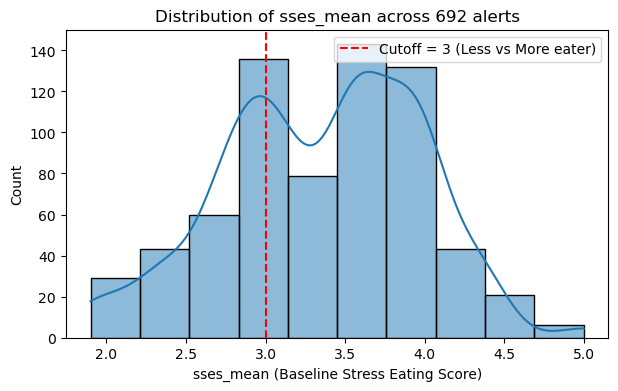

=== Group counts (692 alerts) ===
sses_group
More eater    450
Less eater    242
Name: count, dtype: int64

=== Group ratio (692 alerts) ===
sses_group
More eater    0.650289
Less eater    0.349711
Name: proportion, dtype: float64


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1) sses_mean 분포 확인 ===
plt.figure(figsize=(7,4))
sns.histplot(alerts_with_sses["sses_mean"].dropna(), bins=10, kde=True)
plt.axvline(3, color="red", linestyle="--", label="Cutoff = 3 (Less vs More eater)")
plt.title("Distribution of sses_mean across 692 alerts")
plt.xlabel("sses_mean (Baseline Stress Eating Score)")
plt.ylabel("Count")
plt.legend()
plt.show()

# === 2) 이터 그룹 분류 ===
alerts_with_sses["sses_group"] = alerts_with_sses["sses_mean"].apply(
    lambda x: "Less eater" if x <= 3 else "More eater"
)

# === 3) 비율 확인 ===
group_counts = alerts_with_sses["sses_group"].value_counts()
group_ratio = alerts_with_sses["sses_group"].value_counts(normalize=True)

print("=== Group counts (692 alerts) ===")
print(group_counts)
print("\n=== Group ratio (692 alerts) ===")
print(group_ratio)


# TOP 3 Combination

In [24]:
from collections import Counter
import numpy as np

# 1) 각 샘플별로 SHAP top3 feature index 추출
top3_combos = []
for i in range(shap_pos_clipped.shape[0]):
    # row별 SHAP 값
    row_vals = shap_pos_clipped[i, :]
    
    # top3 index (값 큰 순서)
    top_idx = np.argsort(-row_vals)[:3]
    
    # feature 이름으로 변환
    top_feats = [FEATURES[j] for j in top_idx]
    
    # 조합을 tuple로 (정렬해서 순서 무관하게)
    combo = tuple(sorted(top_feats))
    top3_combos.append(combo)

# 2) 빈도수 집계
combo_counts = Counter(top3_combos)

# 3) 상위 3개 조합 출력
print("\n=== Top 3 most frequent top3-feature combinations (692 alerts) ===")
for combo, count in combo_counts.most_common(10):
    print(f"{combo}: {count} times ({count/692:.2%})")



=== Top 3 most frequent top3-feature combinations (692 alerts) ===
('Time_24h', 'hungry', 'mean_intensity_1h'): 119 times (17.20%)
('Time_24h', 'Z_Previous_4', 'mean_intensity_1h'): 102 times (14.74%)
('Time_24h', 'Z_HR', 'mean_intensity_1h'): 47 times (6.79%)
('15m_G_Diff_7', 'Time_24h', 'mean_intensity_1h'): 42 times (6.07%)
('How_stressed', 'Time_24h', 'mean_intensity_1h'): 41 times (5.92%)
('15m_G_Diff_5', 'Time_24h', 'mean_intensity_1h'): 26 times (3.76%)
('EMA_T_Diff', 'Time_24h', 'mean_intensity_1h'): 24 times (3.47%)
('Time_24h', 'mean_intensity_1h', 'mean_intensity_2h'): 24 times (3.47%)
('G_minus_T_pre_2h', 'Time_24h', 'Z_Previous_4'): 22 times (3.18%)
('Intensity', 'TimeInBed', 'mean_intensity_1h'): 19 times (2.75%)



=== Pairplot for combo: ['Time_24h', 'hungry', 'mean_intensity_1h'] ===


/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


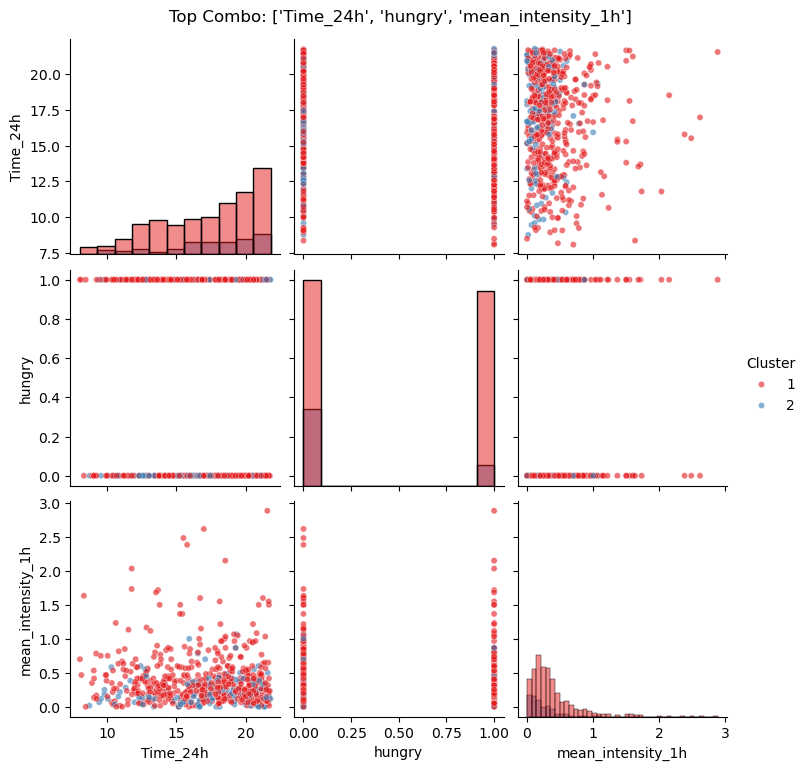


=== Pairplot for combo: ['Time_24h', 'Z_Previous_4', 'mean_intensity_1h'] ===


/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


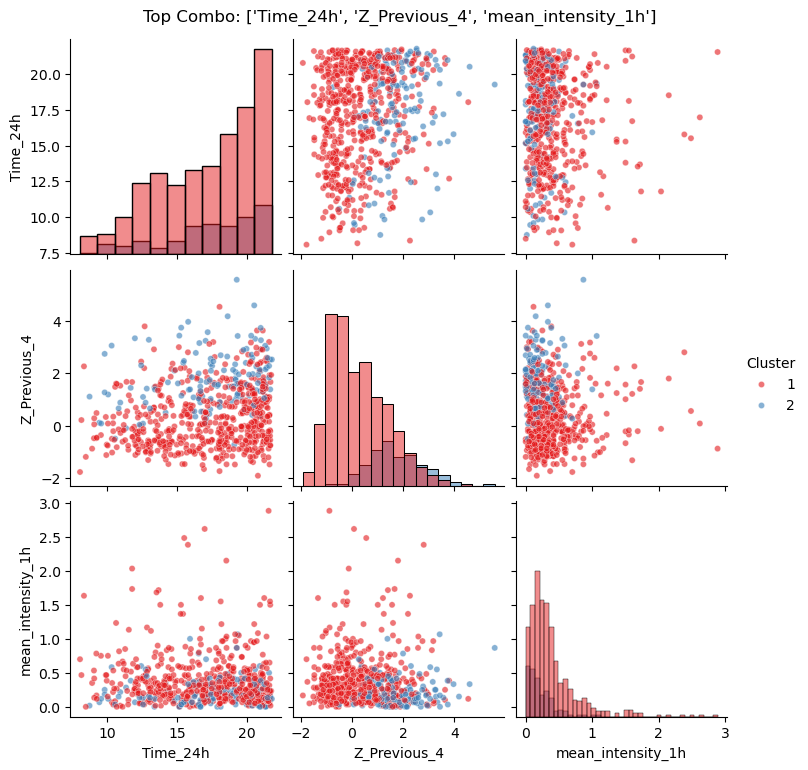


=== Pairplot for combo: ['Time_24h', 'Z_HR', 'mean_intensity_1h'] ===


/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


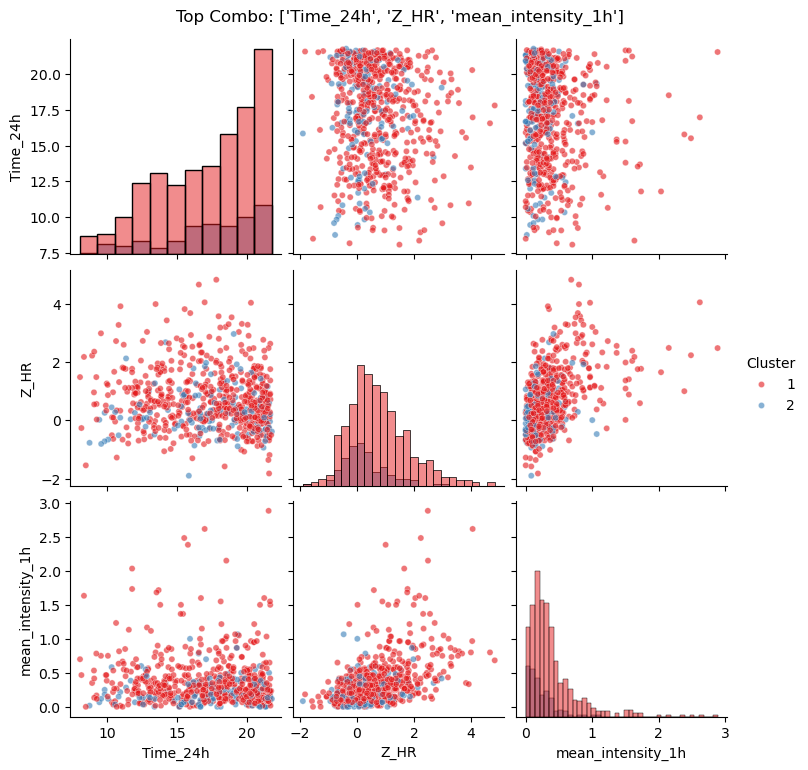


=== Pairplot for combo: ['15m_G_Diff_7', 'Time_24h', 'mean_intensity_1h'] ===


/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


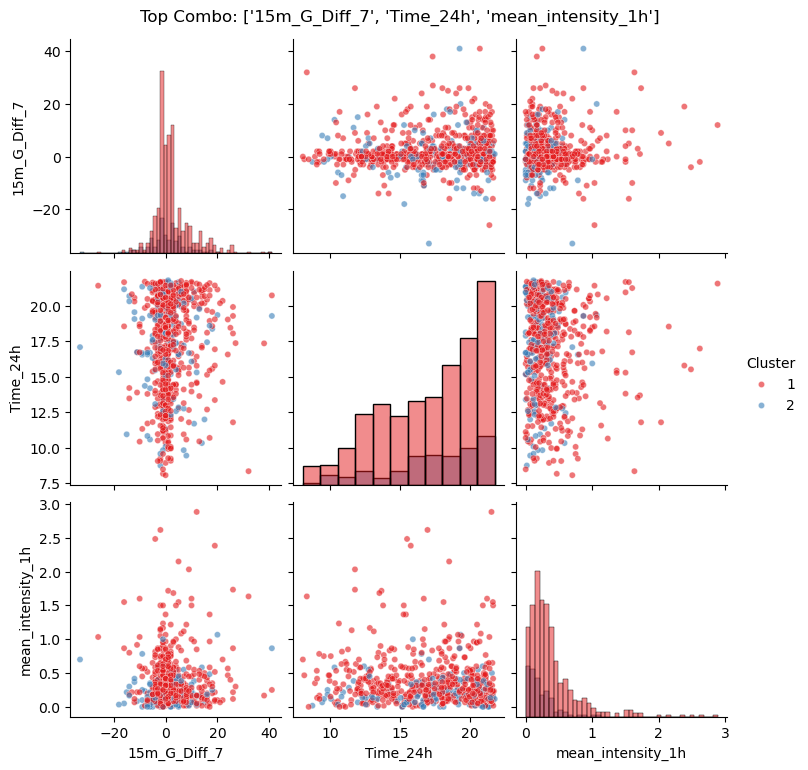


=== Pairplot for combo: ['How_stressed', 'Time_24h', 'mean_intensity_1h'] ===


/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


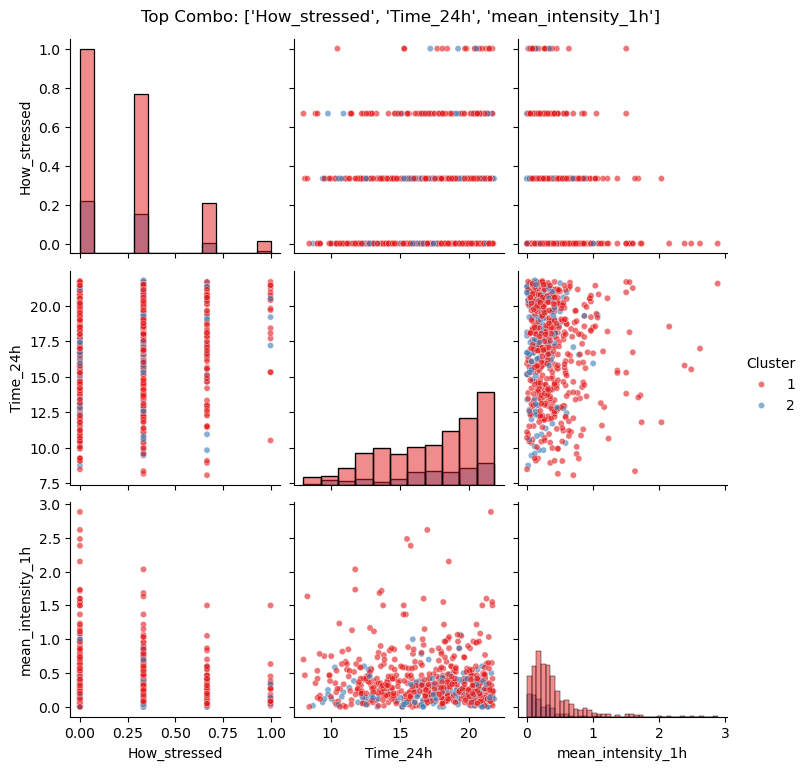

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 5 most frequent combos (each has 3 features)
top_combos = [
    ('Time_24h', 'hungry', 'mean_intensity_1h'),
    ('Time_24h', 'Z_Previous_4', 'mean_intensity_1h'),
    ('Time_24h', 'Z_HR', 'mean_intensity_1h'),
    ('15m_G_Diff_7', 'Time_24h', 'mean_intensity_1h'),
    ('How_stressed', 'Time_24h', 'mean_intensity_1h')
]

# Generate pairplots for each combo
for combo in top_combos:
    feats = list(combo)
    print(f"\n=== Pairplot for combo: {feats} ===")
    
    sns.pairplot(
        data=df_plot,          # Data with cluster labels
        vars=feats,            # Features for this combo
        hue="Cluster",         # Color by cluster
        palette="Set1",
        diag_kind="hist",      # Histogram on diagonals
        plot_kws={"alpha":0.6, "s":20}
    )
    
    plt.suptitle(f"Top Combo: {feats}", y=1.02)
    plt.show()


## The combination of Time_24h, hungry, and mean_intensity_1h appeared most frequently because these variables often had strong positive SHAP contributions. In other words, the model frequently relied on time of day, hunger status, and recent activity intensity as important contextual cues for prediction.

## However, these variables do not separate clusters well since their distributions are fairly similar across all samples.

## In contrast, variables such as Z_Previous_4, G_minus_T_pre_1.5h, and G_minus_T_pre_2h show distributional differences between groups. These glucose-related markers are continuous measures of physiological state, which makes them more effective for clustering.

## In summary: SHAP top features (time, hunger, activity) are best used for real-time triggers, while glucose-pattern variables are more useful for group segmentation.